# Train Monotonic seq2seq

In [1]:
import numpy as np

from scipy.ndimage import gaussian_filter1d

import pandas as pd

import torch

import matplotlib.pyplot as plt

from tqdm import tqdm

from helper import (
    tokenize_text,
    tokenize_ipa,
    Vocabulary,
    pack_indices,
    MonotonicModel,
    transduce,
)

In [2]:
# Load train set
df = pd.read_csv("./train.tsv", sep="\t", na_filter=False, encoding="utf-8")

# Use lowercase text
df["text"] = df["text"].str.lower()

# Discard syllable information
df["pronunciation"] = df["pronunciation"].str.replace(".", "").str.replace("‿", " ")

# Tokenize sequences
df["text_tokens"] = df["text"].apply(tokenize_text)
df["pronunciation_tokens"] = df["pronunciation"].apply(tokenize_ipa)

# Create vocabulary
text_vocab = Vocabulary(t for ts in df["text_tokens"].values for t in ts)
pronunciation_vocab = Vocabulary(t for ts in df["pronunciation_tokens"].values for t in ts)

# Index sequences
df["text_indices"] = df["text_tokens"].apply(text_vocab.encode)
df["pronunciation_indices"] = df["pronunciation_tokens"].apply(pronunciation_vocab.encode)

# Show extract
df

text  \
0                                                anatines   
1                                       omniscientisasses   
2                                             re-répétera   
3                                           recaracoleras   
4                                        désinformeraient   
5                                       performantisèrent   
6                                            autocomprimé   
7                                         feuilletisèrent   
8                                        avoir vu le loup   
9                                            blancoterons   
10                                   consensus laurentien   
11                                             rebobiniez   
12                                                 kurtas   
13                                           boussolerais   
14                                          jeunes mariés   
15                                         repeuplassions   
16                                              frégatidé   
17                                          poudrerizâmes   
18                                          gazouilleuses   
19                                      veines hépatiques   
20                                     effets secondaires   
21                                            cssisassent   
22                                             prussifies   
23      tant va la cruche à l'eau qu'à la fin elle se ...   
24                                               éclissât   
25                                            chocolatier   
26                                          ronchonnerais   
27                                         maisonneraient   
28                                         redocumenterai   
29                                             outplaçait   
...                                                   ...   
155974                                   fouler aux pieds   
155975                                      coup de barre   
155976                                se pogner les mains   
155977                                       mètre pliant   
155978                                 arbres des pagodes   
155979                                  poutres de gloire   
155980                                      érotiseraient   
155981                           courir plusieurs lièvres   
155982                                   maîtres de place   
155983                                     bourrer le mou   
155984                                 sabot de la vierge   
155985                                  sud quart sud-est   
155986                                        préciserait   
155987                                           de merde   
155988                                       chamailleras   
155989                                      chemise brune   
155990                                 comités directeurs   
155991                                          aoûterons   
155992                                 fourmi pot-de-miel   
155993                                        smoked meat   
155994                                  d'autant plus que   
155995                 contrôleurs post-traitement du vih   
155996                                      angevilloises   
155997                                 sainte-catherinois   
155998                                   carnet de chèque   
155999                                     pestes bovines   
156000                                       dollariserai   
156001                                     piste cyclable   
156002                                    maître de place   
156003                           avoir des mollets de coq   

                                   pronunciation  \
0                                         anatin   
1                                  ɔmnisjɑ̃tizas   
2                                     ʁəʁepɛtəʁa   
3                                   ʁəkaʁakɔləʁa   
4         

In [3]:
# Save vocabularies for later
text_vocab.save("text.vocab")
pronunciation_vocab.save("pronunciation.vocab")

In [4]:
# Choose whether to use GPU
cuda = False

In [5]:
# Create model
model = MonotonicModel(
    num_source_symbols=len(text_vocab),
    num_target_symbols=len(pronunciation_vocab),
    embedding_size=16,
    memory_size=64,
    state_size=64,
    attention_size=16,
)
if cuda:
    model = model.cuda()

In [6]:
# Create optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

In [7]:
# Get dataset as arrays
sources = df["text_indices"].values
targets = df["pronunciation_indices"].values
indices = np.arange(len(sources))

# Training hyperparameters
batch_size = 32
max_length = 64
n_batches = (len(indices) - 1) // batch_size + 1
n_epochs = 1

# Train loop
losses = []
for epoch in range(n_epochs):
    np.random.shuffle(indices)
    
    # For each batch...
    with tqdm(range(n_batches)) as progress:
        for batch in progress:

            optimizer.zero_grad()

            idx = indices[batch*batch_size:(batch+1)*batch_size]
            source_inputs, source_lengths = pack_indices(sources[idx])
            target_inputs, target_lengths = pack_indices(targets[idx])

            if cuda:
                source_inputs = source_inputs.cuda()
                source_lengths = source_lengths.cuda()
                target_inputs = target_inputs.cuda()
                target_lengths = target_lengths.cuda()
            
            loss = model(source_inputs, source_lengths, target_inputs, target_lengths)

            loss.backward()
            optimizer.step()

            loss = float(loss.detach().cpu())
            losses.append(loss)
            progress.set_description(f"{loss:.03f}")

0.560: 100%|███████████████████████████████████████████████████████████████████████| 4876/4876 [24:20<00:00,  3.34it/s]


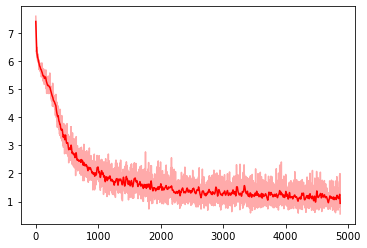

In [8]:
# Plot training loss
fig, ax = plt.subplots()

y = np.array(losses)
x = np.arange(y.shape[0])
y_smooth = gaussian_filter1d(y, 5, mode="nearest")

ax.plot(x, y, c="#ffaaaa")
ax.plot(x, y_smooth, "r")

plt.show()

In [9]:
# Save trained model for later
torch.save(model.state_dict(), "model.pt")

## Evaluate on a few examples

In [10]:
model = MonotonicModel(
    num_source_symbols=len(text_vocab),
    num_target_symbols=len(pronunciation_vocab),
    embedding_size=16,
    memory_size=64,
    state_size=64,
    attention_size=16,
)
model.load_state_dict(torch.load("model.pt"))
model.eval()

MonotonicModel(
  (source_encoder): Encoder(
    (embedding): Embedding(48, 16, padding_idx=0)
    (gru): GRU(16, 64)
  )
  (target_encoder): Encoder(
    (embedding): Embedding(40, 16, padding_idx=0)
    (gru): GRU(16, 64)
  )
  (source_energy): Energy(
    (W): Linear(in_features=64, out_features=16, bias=False)
    (V): Linear(in_features=64, out_features=16, bias=False)
    (v): Linear(in_features=16, out_features=1, bias=True)
  )
  (target_energy): Energy(
    (W): Linear(in_features=64, out_features=16, bias=False)
    (V): Linear(in_features=64, out_features=16, bias=False)
    (v): Linear(in_features=16, out_features=1, bias=True)
  )
  (source_decoder_cell): DecoderCell(
    (state_cell): GRUCell(80, 64)
    (classifier): Linear(in_features=64, out_features=40, bias=True)
  )
  (target_decoder_cell): DecoderCell(
    (state_cell): GRUCell(80, 64)
    (classifier): Linear(in_features=64, out_features=48, bias=True)
  )
)

In [13]:
row = df.iloc[23]
inputs = row["text_indices"]
outputs = row["pronunciation_indices"]
row

text                     tant va la cruche à l'eau qu'à la fin elle se ...
pronunciation                     tɑ̃ va la kʁyʃ a lo k a la fɛ̃ ɛl sə kas
text_tokens              [t, a, n, t,  , v, a,  , l, a,  , c, r, u, c, ...
pronunciation_tokens     [t, ɑ̃,  , v, a,  , l, a,  , k, ʁ, y, ʃ,  , a,...
text_indices             [26, 7, 20, 26, 2, 28, 7, 2, 18, 7, 2, 9, 24, ...
pronunciation_indices    [17, 28, 2, 19, 3, 2, 11, 3, 2, 10, 37, 21, 38...
Name: 23, dtype: object

In [14]:
outputs = [i for _, i in transduce(model, inputs)]
"".join(pronunciation_vocab.decode(outputs))

'tɑ̃ va la kʁyʃ a l  okka ala a fi n sɛl sakasssskas'

In [15]:
inputs = text_vocab.encode(tokenize_text("soigne"))
outputs = [i for _, i in transduce(model, inputs)]
"".join(pronunciation_vocab.decode(outputs))

'swaɲ'

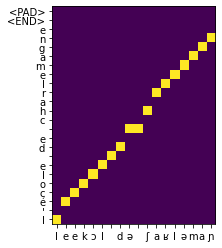

leekɔl də ʃaʁləmaɲ


In [16]:
inputs = text_vocab.encode(tokenize_text("l'école de charlemagne"))

outputs = list(transduce(model, inputs))

fig, ax = plt.subplots()

in_labels = [text_vocab.tokens[i] for i in inputs]
in_labels.append(text_vocab.tokens[0])

matrix = np.zeros((len(inputs) + 1, len(outputs)))
out_labels = []
for j, (i, o) in enumerate(outputs):
    matrix[i, j] = 1
    out_labels.append(pronunciation_vocab.tokens[o])

matrix = matrix[::-1, :]
in_labels = in_labels[::-1]

ax.imshow(matrix)

plt.yticks(range(len(in_labels)), in_labels)
plt.xticks(range(len(out_labels)), out_labels)

plt.show()

print("".join(out_labels))